# Gaussian Process for Stock Prediction

## Load bitcoin stock data
This data was downloaded from Yahoo Finance here (https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD). 

**Stock:** Bitcoin USD (BTC-USD)   
**Data range:** Nov 5, 2019 - Nov 5, 2020

In [1]:
import pandas as pd
stock_data = pd.read_csv('BTC-USD.csv')
stock_data = stock_data

In [2]:
close = stock_data[['Date','Close']]
close

,Date,Close
0,2019-11-05,9342.527344
1,2019-11-06,9360.879883
2,2019-11-07,9267.561523
3,2019-11-08,8804.880859
4,2019-11-09,8813.582031
...,...,...
362,2020-11-01,13737.109375
363,2020-11-02,13550.489258
364,2020-11-03,13950.300781
365,2020-11-04,14133.707031


## Prep data
We have to convert dates to integers to simply capture their sequential nature

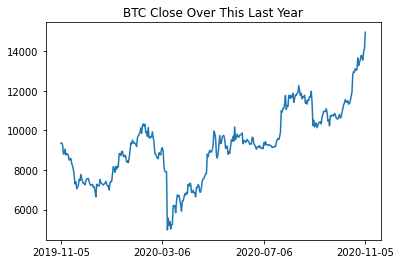

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.xticks(np.linspace(0,len(close) - 1,4))
plt.title('BTC Close Over This Last Year')
plt.plot(close['Date'],close['Close']);

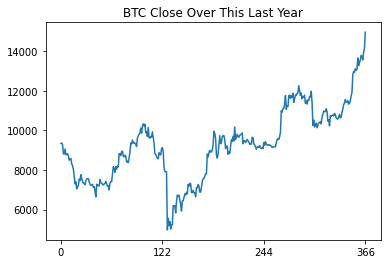

In [4]:
if not 'Day Number' in close.columns:
    close.insert(0,'Day Number', np.arange(0,len(close)))
if 'Date' in close.columns:
    close = close.drop(columns = ['Date'])

plt.xticks(np.linspace(0,len(close) - 1,4))
plt.title('BTC Close Over This Last Year')
plt.plot(close['Day Number'],close['Close']);

We also have to normalize our closing prices

min: 4970.788086, max: 14953.084961000002


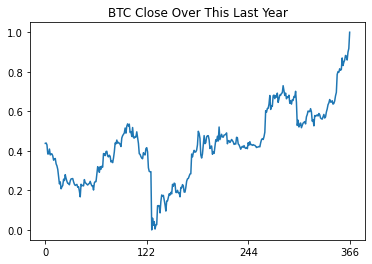

In [5]:
close_min = close['Close'].min()
close_max = close['Close'].max()
print(f'min: {close_min}, max: {close_max}')

norm_values = (close['Close'] - close_min) / (close_max - close_min)
close['Close Norm'] = norm_values
close = close.drop(['Close'], axis=1)

plt.xticks(np.linspace(0,len(close) - 1,4))
plt.title('BTC Close Over This Last Year')
plt.plot(close['Day Number'],close['Close Norm']);

Lets test how normalizing our days between -1 and 1 works so it matches exactly how the sin curve was setup

In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_train = data[:,:,0]
    y_train = data[:,:,-1]
    
    x_test = data_raw[lookback:,0]
    y_test = data_raw[lookback:,1]
    
    return [x_train, y_train, x_test, y_test]

lookback = 7 # choose sequence length
x_train, y_train, x_test, y_test = split_data(close, lookback)

In [7]:
# correct format
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],-1))
y_train = y_train.reshape((y_train.shape[0],x_train.shape[1],-1))
x_test = x_test.reshape(x_test.shape[0],-1)
y_test = y_test.reshape(y_test.shape[0],-1)

## Blog defines our Gaussian Process

In [8]:
# retrieve necessary module if not already downloaded
import os
if not 'gaussian_processes_util.py' in os.listdir():
    !curl -O https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py

In [9]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [11]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [14]:
import random
x = np.array([[1],[2],[3],[4],[5],[6],[7],[8]])
y = np.append(y_train[1],y_train[2,-1])
starting_day = 0
ending_day = 0
predictions = []
covariances = []

for i in range(len(x_train)): #range(len(x_train)):
    
    x_train_sample = x_train[i].astype(int)
    y_train_sample = y_train[i]
    
    x_sample = np.append(x_train_sample,x_test[i])
    y_sample = np.append(y_train_sample, y_test[i])
    x_sample = x_sample.reshape(x_sample.shape[0], -1).astype(int)
    y_sample = y_sample.reshape(y_sample.shape[0], -1)
    
    if i == 0:
        starting_day = x_sample[-1,-1]
    if i == len(x_train)-1:
        ending_day = x_sample[-1,-1]
    
    # Compute mean and covariance of the posterior predictive distribution
    mu_s, cov_s = posterior_predictive(x_sample, x_train_sample, y_train_sample, l=1, sigma_f=1, sigma_y=1e-8)
    predictions = predictions + [mu_s[-1,-1]]
    covariances = covariances + [cov_s[-1,-1]]    
    samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 0)
    
#     plot_gp(mu_s, cov_s, x_sample, X_train=x_train_sample, Y_train=y_train_sample, samples=samples)
#     plt.plot(x_sample, y_sample, label='true', color='g')
#     plt.plot(x_sample, y_sample, color='g')
    
    
#     plt.legend(loc=3);
#     plt.xlim(left=x_sample[-3], right=x_sample[-1])
#     plt.ylim(-1.5,1.5);
    

## Performance
We can see that the model consistently predicts a lower closing price. There are reasons to believe that the curve tries to reach a mean of 0. If we want to predict accurately, we will have remove this bias towards 0.

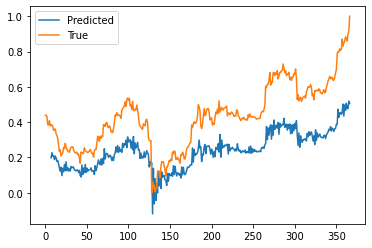

In [15]:
plt.plot(close['Day Number'][starting_day:ending_day+1], predictions, label='Predicted')
plt.plot(close['Day Number'], close['Close Norm'], label='True')
plt.legend();

In [18]:
from sklearn.metrics import mean_squared_error 
Y_true = close['Close Norm'][starting_day:ending_day+1]
Y_pred = predictions

mean_squared_error(Y_true,Y_pred) 

0.04432871895997116